In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
# os.environ["HF_HUB_OFFLINE"] = "1"
# os.environ["MAX_PIXELS"]=


In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import torch
import numpy as np
from qwen_vl_utils import process_vision_info
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg", "pdf")
%matplotlib inline


In [3]:
device = "cuda"
model_path = "Qwen/Qwen2-VL-2B-Instruct"

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
    device_map="auto",
).eval()
processor = AutoProcessor.from_pretrained(
    model_path, trust_remote_code=True, padding_side="left", use_fast=True
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
image_path = "./demo1.png"
question = "what is the date of the photo?"
messages_query = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": f"{question} Answer:"},
        ],
    }
]

image_inputs, _ = process_vision_info(messages_query)

text_query = processor.apply_chat_template(
    messages_query, tokenize=False, add_generation_prompt=True
)

inputs = processor(
    text=[text_query],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(device=model.device, dtype=model.dtype)

messages_general = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text",
                "text": "Write a general description of the image. Answer:",
            },
        ],
    }
]

text_general = processor.apply_chat_template(
    messages_general, tokenize=False, add_generation_prompt=True
)

general_inputs = processor(
    text=[text_general],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(model.device, dtype=model.dtype)

image_inputs_aux = processor.image_processor(images=image_inputs)
output_shape = image_inputs_aux["image_grid_thw"].numpy().squeeze(0)[1:] // 2
output_shape = output_shape.astype(int)


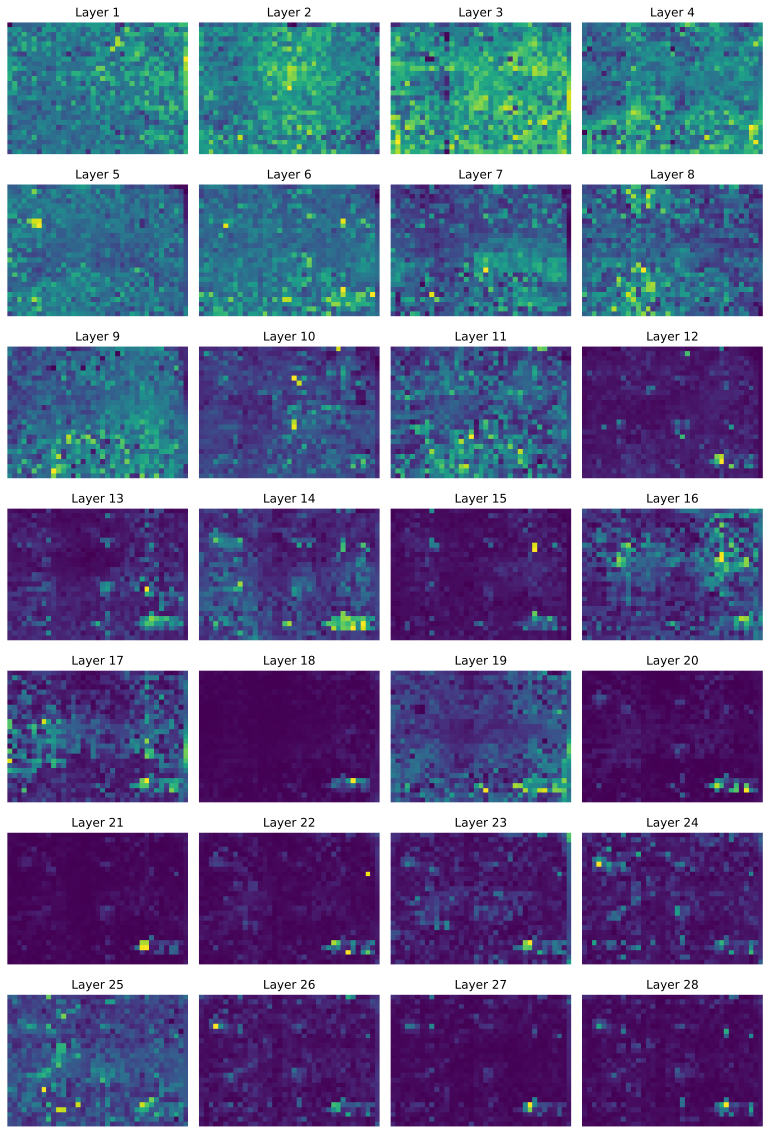

In [5]:
out_attn = None
with torch.no_grad():
    vision_start_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_start|>')
    vision_end_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_end|>')    
    pos = inputs['input_ids'].tolist()[0].index(vision_start_token_id) + 1
    pos_end = inputs['input_ids'].tolist()[0].index(vision_end_token_id)

    output = model(**inputs, output_attentions=True)
    general_output = model(**general_inputs, output_attentions=True)

    fig, axes = plt.subplots(7, 4, figsize=(10.8, 16))
    for i, ax in enumerate(axes.flatten()):
        att = output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
        att = att.to(torch.float32).detach().cpu().numpy()

        general_att = general_output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
        general_att = general_att.to(torch.float32).detach().cpu().numpy()

        att = att / general_att
        if i == 19:
            out_attn = att.reshape(output_shape)

        ax.imshow(att.reshape(output_shape), cmap='viridis', interpolation='nearest')
        ax.set_title(f'Layer {i+1}')
        ax.axis('off')

    plt.tight_layout()    
    plt.show()    


In [7]:
def bbox_from_att_image_adaptive(att_map, image_size, bbox_size=336):
    """
    Generates an adaptive bounding box for original image from an attention map.
    
    This function finds the region with the highest attention in the attention map
    and creates a bounding box around it. It tries different crop ratios and selects
    the one that produces the sharpest attention difference.
    
    Args:
        att_map: A 2D numpy array representing the attention map (e.g., 24x24 for LLaVA or 16x16 for BLIP)
        image_size: Tuple of (width, height) of the original image
        bbox_size: Base size for the bounding box (default: 336)
        
    Returns:
        tuple: (x1, y1, x2, y2) coordinates of the bounding box in the original image
    """

    # the ratios corresponds to the bounding box we are going to crop the image
    ratios = [1, 1.2, 1.4, 1.6, 1.8, 2]

    max_att_poses = []
    differences = []
    block_nums = []

    for ratio in ratios:
        # perform a bbox_size*r width and bbox_size*r height crop, where bbox_size is the size of the model's original image input resolution. (336 for LLaVA, 224 for BLIP)

        # the size of each block in the attention map, in the original image
        block_size = image_size[0] / att_map.shape[1], image_size[1] / att_map.shape[0]

        # if I want a bbox_size*r width and bbox_size*r height crop from the original image, the number of blocks I need (x, y)
        block_num = min(int(bbox_size*ratio/block_size[0]), att_map.shape[1]), min(int(bbox_size*ratio/block_size[1]), att_map.shape[0])
        if att_map.shape[1]-block_num[0] < 1 and att_map.shape[0]-block_num[1] < 1:
            if ratio == 1:
                return 0, 0, image_size[0], image_size[1]
            else:
                continue
        block_nums.append((block_num[0], block_num[1]))
        
        # attention aggregation map
        sliding_att = np.zeros((att_map.shape[0]-block_num[1]+1, att_map.shape[1]-block_num[0]+1))
        max_att = -np.inf
        max_att_pos = (0, 0)

        # sliding window to find the block with the highest attention
        for x in range(att_map.shape[1]-block_num[0]+1): 
            for y in range(att_map.shape[0]-block_num[1]+1): 
                att = att_map[y:y+block_num[1], x:x+block_num[0]].sum()
                sliding_att[y, x] = att
                if att > max_att:
                    max_att = att
                    max_att_pos = (x, y)
        
        # we have the position of max attention, we can calculate the difference between the max attention and the average of its adjacent attentions, to see if it is sharp enough, the more difference, the sharper
        # we choose the best ratio r according to their attention difference
        adjcent_atts = []
        if max_att_pos[0] > 0:
            adjcent_atts.append(sliding_att[max_att_pos[1], max_att_pos[0]-1])
        if max_att_pos[0] < sliding_att.shape[1]-1:
            adjcent_atts.append(sliding_att[max_att_pos[1], max_att_pos[0]+1])
        if max_att_pos[1] > 0:
            adjcent_atts.append(sliding_att[max_att_pos[1]-1, max_att_pos[0]])
        if max_att_pos[1] < sliding_att.shape[0]-1:
            adjcent_atts.append(sliding_att[max_att_pos[1]+1, max_att_pos[0]])
        difference = (max_att - np.mean(adjcent_atts)) / (block_num[0] * block_num[1])
        differences.append(difference)
        max_att_poses.append(max_att_pos)
    max_att_pos = max_att_poses[np.argmax(differences)]
    block_num = block_nums[np.argmax(differences)]
    selected_bbox_size = bbox_size * ratios[np.argmax(differences)]
    
    x_center = int(max_att_pos[0] * block_size[0] + block_size[0] * block_num[0] / 2)
    y_center = int(max_att_pos[1] * block_size[1] + block_size[1] * block_num[1] / 2)
    
    x_center = selected_bbox_size//2 if x_center < selected_bbox_size//2 else x_center
    y_center = selected_bbox_size//2 if y_center < selected_bbox_size//2 else y_center
    x_center = image_size[0] - selected_bbox_size//2 if x_center > image_size[0] - selected_bbox_size//2 else x_center
    y_center = image_size[1] - selected_bbox_size//2 if y_center > image_size[1] - selected_bbox_size//2 else y_center

    x1 = max(0, x_center - selected_bbox_size//2)
    y1 = max(0, y_center - selected_bbox_size//2)
    x2 = min(image_size[0], x_center + selected_bbox_size//2)
    y2 = min(image_size[1], y_center + selected_bbox_size//2)

    return x1, y1, x2, y2


In [8]:
out_attn.shape


(27, 37)

In [9]:
# Crop the image based on the attention map
bbox = bbox_from_att_image_adaptive(out_attn, output_shape.tolist(), 8)
# bbox = tuple(c * 14 for c in bbox)
bbox


(16.0, 23.0, 26.0, 33.0)

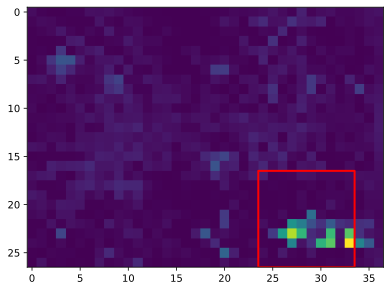

In [ ]:
plt.imshow(out_attn)
# Draw a red rectangle on the attention map to visualize the bbox
from matplotlib.patches import Rectangle

plt.gca().add_patch(
    Rectangle(
        (bbox[1] + 0.5, bbox[0] + 0.5),
        bbox[3] - bbox[1],
        bbox[2] - bbox[0],
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )
)
# plt.axis("off")
plt.show()


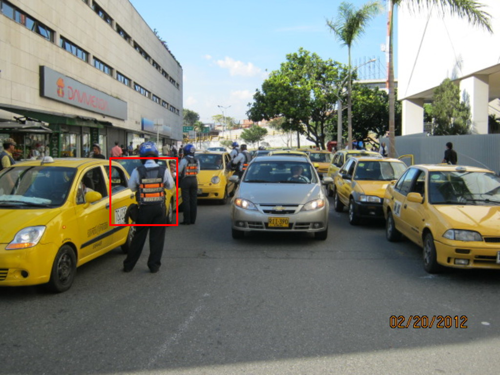

In [14]:
from PIL import Image, ImageDraw

img_bbox = tuple(c * 14 for c in bbox)

image = Image.open(image_path)
image_draw = ImageDraw.Draw(image)
if bbox is not None:
    image_draw.rectangle(img_bbox, outline="red", width=4)
display(image.resize((500, 500 * image.size[1] // image.size[0])))
